In [3]:
!pip install wget
import os
import torch
import pandas as pd
import numpy as np
import torch
from torch import nn


ssh_config = """
Host github.com
  IdentityFile ~/.ssh/github.pem
  User davipeag
  StrictHostKeyChecking no
"""

if os.name == 'nt':
  base_path = ""
  REPO_DIR = "."
  STORE_DIR ="." 
  print("Windows")
else:
  print("Unix-like")
  REPO_DIR = "/tmp/HeartRateRegression"
  from google.colab import drive
  drive.mount('/content/drive')
  GIT_PATH = "/content/drive/My\ Drive/deeplearning_project/github.pem"
  DATA_DIR = os.path.join(REPO_DIR, "repo")
  STORE_DIR ="/content/drive/My Drive/deeplearning_project/" 
  !mkdir ~/.ssh
  !cp -u {GIT_PATH} ~/.ssh/
  !chmod u=rw,g=,o= ~/.ssh/github.pem
  !echo "{ssh_config}" > ~/.ssh/config
  !chmod u=rw,g=,o= ~/.ssh/config
  ! (cd /tmp && git clone git@github.com:davipeag/HeartRateRegression.git)
  ! (cd {REPO_DIR} && git pull )
  import sys
  sys.path.append(REPO_DIR)

def git_pull():
  ! (cd {REPO_DIR} && git pull )

git_pull()

Unix-like
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.ssh’: File exists
fatal: destination path 'HeartRateRegression' already exists and is not an empty directory.
Already up to date.
Already up to date.


In [4]:
import random
import torch
from torch import nn
import numpy as np
args = {
    'epoch_num': 250,     # Number of epochs.
    'lr': 1.0e-3,           # Learning rate.
    'weight_decay': 10e-4, # L2 penalty.
    'momentum': 0.9,      # Momentum.
    'num_workers': 0,     # Number of workers on data loader.
    'batch_size': 128,     # Mini-batch size. 128
    'batch_test': 248,     # size of test batch
    'window': 15,
    'initial_window':5,
    'clip_norm': 6.0,     # Upper limit on gradient L2 norm ###
}
if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

SEED = 1234
def reset_seeds():
  random.seed(SEED)
  np.random.seed(SEED)
  torch.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  torch.cuda.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

reset_seeds()

cuda


In [5]:
from data_utils import (Pamap2Handler, FormatPamap)

SUBJECTS = list(range(1,9))

handler = Pamap2Handler(DATA_DIR)
formatter = FormatPamap()
dfs_train = [formatter.transform(handler.get_protocol_subject(i)) for i in SUBJECTS]
[len(df)//200 for df in dfs_train]

[1882, 2235, 1264, 1647, 1873, 1809, 1567, 2040]

In [6]:
git_pull()

import importlib

import PPG
import preprocessing_utils
from PPG import FullTrainer
import RegressionHR

from RegressionHR import FullTrainer
from RegressionHR import PceLstmDefaults
from RegressionHR import PceLstmModel
from RegressionHR import TrainerJoint
from RegressionHR import  UtilitiesData


importlib.reload(PPG.AttentionDefaults)
importlib.reload(PPG)
importlib.reload(PPG.UtilitiesDataXY)
importlib.reload(PPG.Models)
importlib.reload(PPG.NoHrPceLstmModel)
importlib.reload(PPG.TrainerXY)
importlib.reload(PPG.TrainerIS)
importlib.reload(PPG.FullTrainer)
importlib.reload(PceLstmDefaults)
importlib.reload(preprocessing_utils)
importlib.reload(RegressionHR)
importlib.reload(RegressionHR.FullTrainer)
importlib.reload(RegressionHR.PceLstmDefaults)
importlib.reload(PPG.UtilitiesDataXY)
importlib.reload(preprocessing_utils)
importlib.reload(RegressionHR.TrainerJoint)
importlib.reload(RegressionHR.UtilitiesData)
importlib.reload(RegressionHR.PceLstmModel)
importlib.reload(preprocessing_utils)


Already up to date.


<module 'preprocessing_utils' from '/tmp/HeartRateRegression/preprocessing_utils.py'>

In [7]:
import matplotlib.pyplot as plt
import pickle

def compute_ensemble(results):
  
  ys = [v["predictions"][0].reshape(-1).numpy() for v in results]
  min_len_y = min([len(y) for y in ys])
  ys = [y[:min_len_y] for y in ys]
  for i in range(1, len(ys)-1):
    assert np.all(ys[i] == ys[i-1])
  ps = np.stack([v["predictions"][1].reshape(-1).numpy()[:min_len_y] for v in results])

  s = ps[0]
  for p in ps[1:]:
    s = s + p

  a = s/len(ps)
  y = ys[0]

  plt.figure()
  plt.plot(a)
  plt.plot(y)
  plt.show()

  return np.mean(np.abs(a - y)), np.mean(np.abs(ps - y))



{'alpha': 0.6, 'ts_per_samples': [50], 'val_sub': 4, 'ts_sub': 0, 'batch_size': 64, 'weight_decay': 0.0, 'lr': 0.001, 'nattrs': 40, 'dropout_rate': 0.15, 'lstm_input': 64, 'lstm_size': 128, 'ts_h_size': 16} (16.871006, 0.6207008361816406)


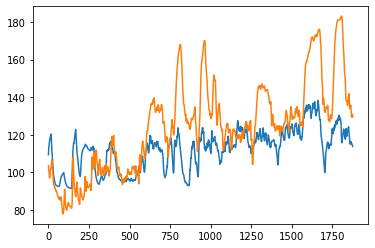

0-TS:(16.871006, 16.871006)
{'alpha': 0.6, 'ts_per_samples': [50], 'val_sub': 4, 'ts_sub': 1, 'batch_size': 64, 'weight_decay': 0.0, 'lr': 0.001, 'nattrs': 40, 'dropout_rate': 0.15, 'lstm_input': 64, 'lstm_size': 128, 'ts_h_size': 16} (12.222516, 0.6127597689628601)


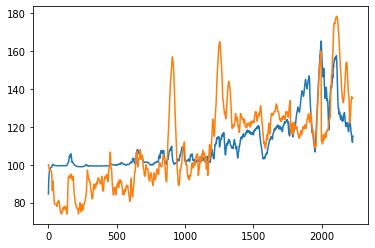

1-TS:(12.222516, 12.222516)
{'alpha': 0.6, 'ts_per_samples': [50], 'val_sub': 4, 'ts_sub': 2, 'batch_size': 64, 'weight_decay': 0.0, 'lr': 0.001, 'nattrs': 40, 'dropout_rate': 0.15, 'lstm_input': 64, 'lstm_size': 128, 'ts_h_size': 16} (13.540187, 1.3086026906967163)


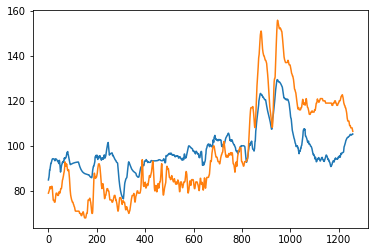

2-TS:(13.540187, 13.540187)
{'alpha': 0.6, 'ts_per_samples': [50], 'val_sub': 4, 'ts_sub': 3, 'batch_size': 64, 'weight_decay': 0.0, 'lr': 0.001, 'nattrs': 40, 'dropout_rate': 0.15, 'lstm_input': 64, 'lstm_size': 128, 'ts_h_size': 16} (10.8674555, 0.5556804537773132)


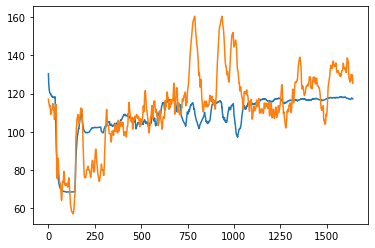

3-TS:(10.8674555, 10.8674555)
{'alpha': 0.6, 'ts_per_samples': [50], 'val_sub': 4, 'ts_sub': 5, 'batch_size': 64, 'weight_decay': 0.0, 'lr': 0.001, 'nattrs': 40, 'dropout_rate': 0.15, 'lstm_input': 64, 'lstm_size': 128, 'ts_h_size': 16} (15.649845, 0.6679169535636902)


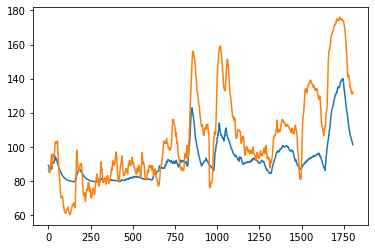

5-TS:(15.649845, 15.649845)
{'alpha': 0.6, 'ts_per_samples': [50], 'val_sub': 4, 'ts_sub': 6, 'batch_size': 64, 'weight_decay': 0.0, 'lr': 0.001, 'nattrs': 40, 'dropout_rate': 0.15, 'lstm_input': 64, 'lstm_size': 128, 'ts_h_size': 16} (13.497497, 0.5866199731826782)


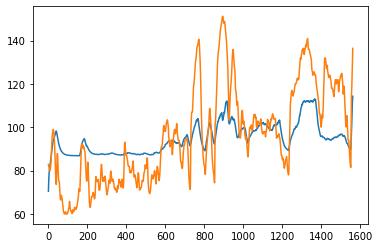

6-TS:(13.497497, 13.497497)
{'alpha': 0.6, 'ts_per_samples': [50], 'val_sub': 4, 'ts_sub': 7, 'batch_size': 64, 'weight_decay': 0.0, 'lr': 0.001, 'nattrs': 40, 'dropout_rate': 0.15, 'lstm_input': 64, 'lstm_size': 128, 'ts_h_size': 16} (24.55683, 0.5273228883743286)


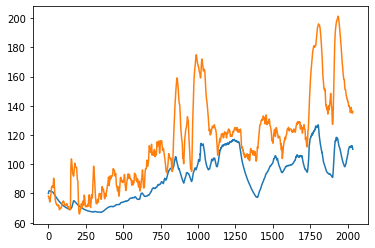

7-TS:(24.55683, 24.55683)
{'alpha': 0.6, 'ts_per_samples': [50], 'val_sub': 5, 'ts_sub': 0, 'batch_size': 64, 'weight_decay': 0.0, 'lr': 0.001, 'nattrs': 40, 'dropout_rate': 0.15, 'lstm_input': 64, 'lstm_size': 128, 'ts_h_size': 16} (15.438318, 0.7208271622657776)


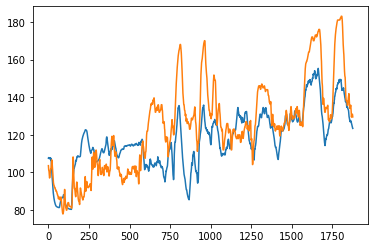

0-TS:(14.211427, 16.154661)
{'alpha': 0.6, 'ts_per_samples': [50], 'val_sub': 5, 'ts_sub': 1, 'batch_size': 64, 'weight_decay': 0.0, 'lr': 0.001, 'nattrs': 40, 'dropout_rate': 0.15, 'lstm_input': 64, 'lstm_size': 128, 'ts_h_size': 16} (13.4839115, 0.5171728730201721)


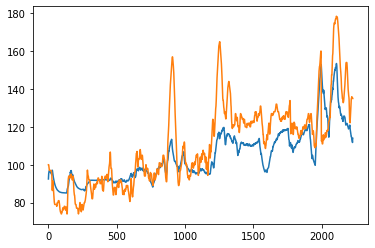

1-TS:(10.205271, 12.853213)
{'alpha': 0.6, 'ts_per_samples': [50], 'val_sub': 5, 'ts_sub': 2, 'batch_size': 64, 'weight_decay': 0.0, 'lr': 0.001, 'nattrs': 40, 'dropout_rate': 0.15, 'lstm_input': 64, 'lstm_size': 128, 'ts_h_size': 16} (5.2452407, 0.5101431608200073)


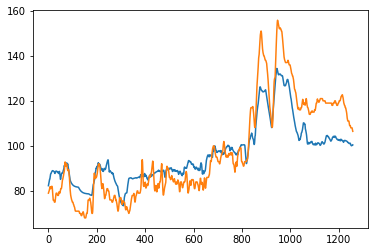

2-TS:(8.584786, 9.392714)
{'alpha': 0.6, 'ts_per_samples': [50], 'val_sub': 5, 'ts_sub': 3, 'batch_size': 64, 'weight_decay': 0.0, 'lr': 0.001, 'nattrs': 40, 'dropout_rate': 0.15, 'lstm_input': 64, 'lstm_size': 128, 'ts_h_size': 16} (21.612635, 0.690268337726593)


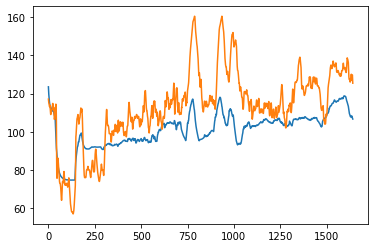

3-TS:(14.581013, 16.240044)
{'alpha': 0.6, 'ts_per_samples': [50], 'val_sub': 5, 'ts_sub': 4, 'batch_size': 64, 'weight_decay': 0.0, 'lr': 0.001, 'nattrs': 40, 'dropout_rate': 0.15, 'lstm_input': 64, 'lstm_size': 128, 'ts_h_size': 16} (19.028574, 0.5491219162940979)


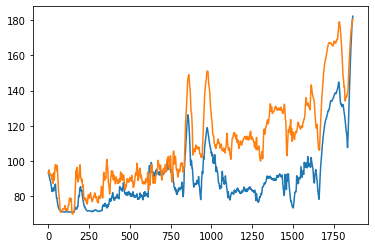

4-TS:(19.028574, 19.028574)


KeyboardInterrupt: ignored

In [8]:

# fchoice = {
#   'alpha': 0.6, 
#   'ts_per_samples': [50], 
#   'val_sub': 4,
#   'ts_sub': 5, 
#   'batch_size': 64, 
#   'weight_decay': 0.0, 
#   'lr': 0.001, 
#   'nattrs': 40,
#   'dropout_rate': 0.15, 
#   'lstm_input': 64, 
#   'lstm_size': 128, 
#   'ts_h_size': 16}


# from PPG import UtilitiesDataXY
# from collections import defaultdict
# nepoch = 80
# aresults = defaultdict(dict)
# for val_sub in [4,5,3,2,1,0,6,7]:
#   for ts_sub in range(8):
#     if val_sub == ts_sub:
#       continue
#     fchoice["ts_sub"] = ts_sub
#     fchoice["val_sub"] = val_sub
#     filename = f"pamap_ts_{ts_sub}_val_{val_sub}_alpha_{fchoice['alpha']}_nepoch_{nepoch}.pkl"
#     save_path = os.path.join(STORE_DIR, filename)
#     try:
#       with open(save_path , "rb") as f:
#         out = pickle.load(f)
#     except FileNotFoundError:
#       full_trainer = RegressionHR.FullTrainer.PceLstmDiscriminatorFullTrainer(dfs_train, args["device"], nepoch)
#       try:
#         out = full_trainer.train(**fchoice)
#         with open(save_path, "wb") as f:
#           pickle.dump(out, f)

#       except RuntimeError as e:
#         if isinstance(e, KeyboardInterrupt):
#           raise e
#         else:
#           print("####")
#           print(f"Failed: {choice}")
#           print("###")
    
#     print(out["args"], out["metric"])
#     aresults[ts_sub][val_sub] = out
#     print(f"{ts_sub}-TS:{compute_ensemble(list(aresults[ts_sub].values()))}")
    



In [9]:
import matplotlib.pyplot as plt
import pickle

fchoice = {
  'alpha': 0.7, 
  'ts_per_samples': [50], 
  'val_sub': 4,
  'ts_sub': 5, 
  'batch_size': 64, 
  'weight_decay': 0.0, 
  'lr': 0.001, 
  'nattrs': 40,
  'dropout_rate': 0.15, 
  'lstm_input': 64, 
  'lstm_size': 128, 
  'ts_h_size': 16,
  'ts_per_is': 8}


from PPG import UtilitiesDataXY
from collections import defaultdict
nepoch = 80
aresults = defaultdict(dict)
for val_sub in [5,4, 3,2,1,0,6,7]:
  for ts_sub in range(8):
    if val_sub == ts_sub:
      continue
    fchoice["ts_sub"] = ts_sub
    fchoice["val_sub"] = val_sub
    filename = f"pamap_ts_{ts_sub}_val_{val_sub}_alpha_{fchoice['alpha']}-joint_val_nepoch_{nepoch}.pkl"
    save_path = os.path.join(STORE_DIR, filename)
    try:
      raise FileNotFoundError
      with open(save_path , "rb") as f:
        out = pickle.load(f)
    except FileNotFoundError:
      full_trainer = RegressionHR.FullTrainer.PceLstmDiscriminatorFullTrainerJointValidation2(dfs_train, args["device"], nepoch)
      try:
        out = full_trainer.train(**fchoice)
        with open(save_path, "wb") as f:
          pickle.dump(out, f)

      except RuntimeError as e:
        if isinstance(e, KeyboardInterrupt):
          raise e
        else:
          print("####")
          print(f"Failed: {choice}")
          print("###")
    
    print(out["args"], out["metric"])
    aresults[ts_sub][val_sub] = out
    print(f"{ts_sub}-TS:{compute_ensemble(list(aresults[ts_sub].values()))}")
    



about to train:
best val epoch: 1
[1/80]: loss_train: (20.462954, 0.6912705898284912) loss_val (17.87814, 0.6935390830039978) loss_ts (22.231401, 0.6933228373527527)
best val epoch: 2
[2/80]: loss_train: (17.319845, 0.6897211074829102) loss_val (15.753268, 0.6938613057136536) loss_ts (19.33877, 0.691379964351654)
best val epoch: 3
[3/80]: loss_train: (14.886136, 0.6879319548606873) loss_val (13.858631, 0.6945353746414185) loss_ts (23.927952, 0.6911435127258301)
best val epoch: 4
[4/80]: loss_train: (12.438401, 0.6862325668334961) loss_val (11.202233, 0.6967141032218933) loss_ts (27.842543, 0.6912926435470581)
best val epoch: 5
[5/80]: loss_train: (11.198548, 0.6846706867218018) loss_val (9.446049, 0.6986631155014038) loss_ts (36.40709, 0.6916001439094543)
best val epoch: 13
[13/80]: loss_train: (10.028763, 0.6755896210670471) loss_val (8.576098, 0.7183485627174377) loss_ts (24.232265, 0.6959271430969238)
best val epoch: 32
[32/80]: loss_train: (9.373455, 0.6625890731811523) loss_val (8

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt
import pickle

fchoice = {
  'alpha': 0.6, 
  'ts_per_samples': [50], 
  'val_sub': 4,
  'ts_sub': 5, 
  'batch_size': 64, 
  'weight_decay': 0.0, 
  'lr': 0.001, 
  'nattrs': 40,
  'dropout_rate': 0.15, 
  'lstm_input': 64, 
  'lstm_size': 128, 
  'ts_h_size': 16,
  'step_s': 4}


from PPG import UtilitiesDataXY
from collections import defaultdict
nepoch = 80
aresults = defaultdict(dict)
for val_sub in [4]:
  for ts_sub in range(8):
    if val_sub == ts_sub:
      continue
    fchoice["ts_sub"] = ts_sub
    fchoice["val_sub"] = val_sub
    filename = f"pamap_ts_{ts_sub}_val_{val_sub}_alpha_{fchoice['alpha']}-joint_val_nepoch_{nepoch}_step4.pkl"
    save_path = os.path.join(STORE_DIR, filename)
    try:
      with open(save_path , "rb") as f:
        out = pickle.load(f)
    except FileNotFoundError:
      full_trainer = RegressionHR.FullTrainer.PceLstmDiscriminatorFullTrainerJointValidation(dfs_train, args["device"], nepoch)
      try:
        out = full_trainer.train(**fchoice)
        with open(save_path, "wb") as f:
          pickle.dump(out, f)

      except RuntimeError as e:
        if isinstance(e, KeyboardInterrupt):
          raise e
        else:
          print("####")
          print(f"Failed: {choice}")
          print("###")
    
    print(out["args"], out["metric"])
    aresults[ts_sub][val_sub] = out
    print(f"{ts_sub}-TS:{compute_ensemble(list(aresults[ts_sub].values()))}")
    



In [ ]:
import matplotlib.pyplot as plt
import pickle

fchoice = {
  'alpha': 1, 
  'ts_per_samples': [50], 
  'val_sub': 4,
  'ts_sub': 5, 
  'batch_size': 64, 
  'weight_decay': 0.0, 
  'lr': 0.001, 
  'nattrs': 40,
  'dropout_rate': 0.15, 
  'lstm_input': 64, 
  'lstm_size': 128, 
  'ts_h_size': 16}


from PPG import UtilitiesDataXY
from collections import defaultdict
nepoch = 80
aresults = defaultdict(dict)
for val_sub in [4]:
  for ts_sub in range(8):
    if val_sub == ts_sub:
      continue
    fchoice["ts_sub"] = ts_sub
    fchoice["val_sub"] = val_sub
    filename = f"pamap_ts_{ts_sub}_val_{val_sub}_alpha_{fchoice['alpha']}-joint_val_nepoch_{nepoch}.pkl"
    save_path = os.path.join(STORE_DIR, filename)
    try:
      with open(save_path , "rb") as f:
        out = pickle.load(f)
    except FileNotFoundError:
      full_trainer = RegressionHR.FullTrainer.PceLstmDiscriminatorFullTrainerJointValidation(dfs_train, args["device"], nepoch)
      try:
        out = full_trainer.train(**fchoice)
        with open(save_path, "wb") as f:
          pickle.dump(out, f)

      except RuntimeError as e:
        if isinstance(e, KeyboardInterrupt):
          raise e
        else:
          print("####")
          print(f"Failed: {choice}")
          print("###")
    
    print(out["args"], out["metric"])
    aresults[ts_sub][val_sub] = out
    print(f"{ts_sub}-TS:{compute_ensemble(list(aresults[ts_sub].values()))}")
    



In [ ]:
import matplotlib.pyplot as plt
import pickle

fchoice = {
  'alpha': 1, 
  'ts_per_samples': [50], 
  'val_sub': 4,
  'ts_sub': 5, 
  'batch_size': 64, 
  'weight_decay': 0.0, 
  'lr': 0.001, 
  'nattrs': 40,
  'dropout_rate': 0.15, 
  'lstm_input': 64, 
  'lstm_size': 128, 
  'ts_h_size': 16,
  'step_s': 4}


from PPG import UtilitiesDataXY
from collections import defaultdict
nepoch = 80
aresults = defaultdict(dict)
for val_sub in [4]:
  for ts_sub in range(8):
    if val_sub == ts_sub:
      continue
    fchoice["ts_sub"] = ts_sub
    fchoice["val_sub"] = val_sub
    filename = f"pamap_ts_{ts_sub}_val_{val_sub}_alpha_{fchoice['alpha']}-joint_val_nepoch_{nepoch}_step_{fchoice['step_s']}.pkl"
    save_path = os.path.join(STORE_DIR, filename)
    try:
      with open(save_path , "rb") as f:
        out = pickle.load(f)
    except FileNotFoundError:
      full_trainer = RegressionHR.FullTrainer.PceLstmDiscriminatorFullTrainerJointValidation(dfs_train, args["device"], nepoch)
      try:
        out = full_trainer.train(**fchoice)
        with open(save_path, "wb") as f:
          pickle.dump(out, f)

      except RuntimeError as e:
        if isinstance(e, KeyboardInterrupt):
          raise e
        else:
          print("####")
          print(f"Failed: {choice}")
          print("###")
    
    print(out["args"], out["metric"])
    aresults[ts_sub][val_sub] = out
    print(f"{ts_sub}-TS:{compute_ensemble(list(aresults[ts_sub].values()))}")
    



In [ ]:
import matplotlib.pyplot as plt
import pickle

fchoice = {
  'alpha': 0.6, 
  'ts_per_samples': [50], 
  'val_sub': 4,
  'ts_sub': 5, 
  'batch_size': 64, 
  'weight_decay': 0.0, 
  'lr': 0.001, 
  'nattrs': 40,
  'dropout_rate': 0.15, 
  'lstm_input': 64, 
  'lstm_size': 128, 
  'ts_h_size': 16}


from PPG import UtilitiesDataXY
from collections import defaultdict
nepoch = 80
aresults = defaultdict(dict)
for val_sub in [4,5,3,2,1,0,6,7]:
  for ts_sub in range(8):
    if val_sub == ts_sub:
      continue
    fchoice["ts_sub"] = ts_sub
    fchoice["val_sub"] = val_sub
    filename = f"pamap_ts_{ts_sub}_val_{val_sub}_alpha_{fchoice['alpha']}-joint_val_nepoch_{nepoch}.pkl"
    save_path = os.path.join(STORE_DIR, filename)
    try:
      with open(save_path , "rb") as f:
        out = pickle.load(f)
    except FileNotFoundError:
      full_trainer = RegressionHR.FullTrainer.PceLstmDiscriminatorFullTrainerJointValidation(dfs_train, args["device"], nepoch)
      try:
        out = full_trainer.train(**fchoice)
        with open(save_path, "wb") as f:
          pickle.dump(out, f)

      except RuntimeError as e:
        if isinstance(e, KeyboardInterrupt):
          raise e
        else:
          print("####")
          print(f"Failed: {choice}")
          print("###")
    
    print(out["args"], out["metric"])
    aresults[ts_sub][val_sub] = out
    print(f"{ts_sub}-TS:{compute_ensemble(list(aresults[ts_sub].values()))}")
    



In [ ]:
import random 
# options  = {'val_sub': [4],
#   'ts_sub': [5],
#   'batch_size': [64],
#   'weight_decay': [0.0001, 0.000],
#   'lr': [0.001, 0.005, 0.0001, 0.0005],
#   'nattrs': [40],
#   'dropout_rate': [0, 0.15, 0.25, 0.35, 0.50],
#   'lstm_input': [32, 64, 128],
#   'lstm_size': [16, 32, 64],
#   'ts_h_size': [16, 32, 64],
#   'ts_per_samples':[[40]],
#   'alpha': [0.5, 0.6, 0.7, 0.8]
#   }

options = {
        'val_sub': [4],
        'ts_sub': [5],
  'batch_size': [64],
  'weight_decay': [0.0001, 0.00001, 0.0],
  'lr': [0.001, 0.005, 0.0001, 0.0005],
  'nattrs': [40],
  'dropout_rate': [0, 0.15,0.25, 0.5],
  'lstm_input': [16, 32, 64, 128],
  'lstm_size': [16, 32, 64, 128],
  'ts_h_size': [16, 32, 64, 128],
  'ts_per_samples':[[30], [40], [50]],
  'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
  }


def choose(options):
  choice = dict()
  for k,v in options.items():
    choice[k] = random.choice(v)
  return choice

from  Optimization.Optimizers import RandomSearch
import json
import pickle

filename = "pamap_pce_lstm_discriminator_results.pkl"
save_path = os.path.join(STORE_DIR, filename)

try:
  with open(save_path, "rb") as f:
    results = pickle.load(f)
except FileNotFoundError:
  results = list()

full_trainer = RegressionHR.FullTrainer.PceLstmDiscriminatorFullTrainer(dfs_train, args["device"], 40)
searcher = RandomSearch(full_trainer, options)
searcher.results = results
while True:
  searcher.fit(1)
  with open(save_path, "wb") as f:
    pickle.dump(searcher.results, f)

In [ ]:

def compute_ensemble(results):
  ps = [v["predictions"][1].reshape(-1).numpy() for v in results]
  ys = [v["predictions"][0].reshape(-1).numpy() for v in results]

  for i in range(1, len(ys)-1):
    assert np.all(ys[i] == ys[i-1])

  s = ps[0]
  for p in ps[1:]:
    s = s + p

  a = s/len(ps)
  y = ys[0]

  plt.plot(a)
  plt.plot(y)

  np.mean(np.abs(a - y))

compute_ensemble(dresults)

# import matplotlib.pyplot as plt


# p = p.reshape(-1)

# plt.plot(y)
# plt.plot(p)


In [ ]:
import random 
options = {
  "ts_h_size": [64, 128],
  "lstm_size": [64, 64, 128],
  "lstm_input": [64, 128, 256],
  "dropout_rate": [0.25],
  "bvp_count": [8,16],
  "nattrs": [5],
  'lr': [0.001],
  'weight_decay': [0, 0.0001],
  'batch_size': [64, 128, 256],
  'ts_sub': [0],
  'val_sub': [4]
 }

def choose(options):
  choice = dict()
  for k,v in options.items():
    choice[k] = random.choice(v)
  return choice


In [ ]:
results = list()
from PPG import UtilitiesDataXY
while True:
  full_trainer = FullTrainer.NoHrPceLstmFullTrainer(dfs_train, args["device"])
  choice = choose(options)
  try:
    out = full_trainer.train(**choice)
    print(out["args"], out["metric"])
    results.append([out["args"], out["metric"]])
  except RuntimeError as e:
    if isinstance(e, KeyboardInterrupt):
      raise e
    else:
      print("####")
      print(f"Failed: {choice}")
      print("###")

In [ ]:
results

In [ ]:
fchoice = {'val_sub': 4,
  'ts_sub': 0,
  'batch_size': 64,
  'weight_decay': 0,
  'lr': 0.001,
  'nattrs': 5,
  'bvp_count': 16,
  'dropout_rate': 0.25,
  'lstm_input': 128,
  'lstm_size': 64,
  'ts_h_size': 64}


dresults = list()
from PPG import UtilitiesDataXY
ts_sub = 3
for val_sub in [i for i in range(15) if i != ts_sub]:
  full_trainer = FullTrainer.NoHrPceLstmFullTrainer(dfs_train, args["device"])
  try:
    fchoice["ts_sub"] = ts_sub
    fchoice["val_sub"] = val_sub
    out = full_trainer.train(**fchoice)
    print(out["args"], out["metric"])
    dresults.append([out])
  except RuntimeError as e:
    if isinstance(e, KeyboardInterrupt):
      raise e
    else:
      print("####")
      print(f"Failed: {choice}")
      print("###")

In [ ]:
y = 

In [ ]:
full_trainer = FullTrainer.AttentionFullTrainer(dfs_train, args["device"], 0, 1)

full_trainer.train()

In [ ]:
from PPG import UtilitiesDataXY 


transformers = PPG.AttentionDefaults.get_preprocessing_transformer()
make_loaders = UtilitiesDataXY.DataLoaderFactory(transformers, dfs_train).make_loaders

loader_tr, loader_val, loader_ts = make_loaders(ts_sub=0, val_sub=1)

In [ ]:
from PPG.Models import SnippetConvolutionalTransformer

net = SnippetConvolutionalTransformer().to(args["device"])

# x,y = next(iter(loader_tr))

# p = net(x)

criterion = nn.MSELoss().to(args["device"])# nn.L1Loss().to(args["device"]) #nn.CrossEntropyLoss().to(args["device"])
optimizer = torch.optim.Adam(net.parameters(), lr=args["lr"],
                             weight_decay=args["weight_decay"])


In [ ]:
from PPG.TrainerXY import (EpochTrainerXY, MetricsComputerXY, TrainHelperXY)
from preprocessing_utils import ZTransformer2

epoch_trainer = EpochTrainerXY(net, optimizer, criterion, args["device"])
ztransformer = ZTransformer2(['heart_rate', 'wrist-ACC-0', 'wrist-ACC-1', 'wrist-ACC-2',
              'wrist-BVP-0', 'wrist-EDA-0', 'wrist-TEMP-0', 'chest-ACC-0',
              'chest-ACC-1', 'chest-ACC-2', 'chest-Resp-0'])
metrics_comuter = MetricsComputerXY(ztransformer)

train_helper = TrainHelperXY(epoch_trainer, loader_tr, loader_val, loader_ts, metrics_comuter.mae)

In [ ]:
train_helper.train(30)